<h1 style="text-align:center;">Numerical Quantum Mechanics</h1>
<h2 style="text-align:center;">1D Schrodinger Equation using Finite Difference</h2>
<h3 style="text-align:center;">Fadjar Fathurrahman</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
%matplotlib inline

In [3]:
import matplotlib
matplotlib.style.use("default")

In [4]:
import scipy.linalg

**Problem** Find stationary states of the Schrodinger equation:

$$
\left[ -\frac{\hbar^2}{2m} \frac{\mathrm{d}^2}{\mathrm{d}x^2} + V(x) \right] \psi(x) = E \psi(x)
$$

We will use 2nd order finite difference to approximate $\dfrac{\mathrm{d}^2}{\mathrm{d}x^2}$ operator.

$$
\frac{\mathrm{d}^2}{\mathrm{d}x^2}\psi(x_{i}) \approx
\frac{ \psi(x_{i} + h) - 2\psi(x_{i}) + \psi(x_{i} - h)}{h^2}
$$

We will discretize $\psi(x)$ in the domain:

$$
\left[ x_{\text{min}}, x_{\text{max}} \right]
$$

using regularly-spaced grid points $x_{i}$, $i = 1,2,\ldots,N$. The spacing $h$ can be calculated as:

$$
h = \frac{x_{\text{max}} - x_{\text{min}}}{N-1}
$$

The points $x_{i}$ can be generated as:
$$
x_{i} = x_{\text{min}} + (i-1)h
$$
with $i = 1,2,\ldots,N$

In Python the array index starts from 0. We can use the following code to generate the grid points. For example, we will use $N=10$.

In [34]:
N = 10
x_min = -5.0
x_max = 5.0
L = x_max - x_min
h = L/(N-1)
x = np.zeros(N)
for i in range(N):
    x[i] = x_min + i*h

In [35]:
x

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

Suppose that we have the following function:

$$
f(x) = \text{e}^{-\alpha x^2}
$$

We will sample this function using on our grid points.

In [48]:
def my_gaussian(x, α=1.0):
    return np.exp(-α*x**2)

Note that, I have defined the parameter `α` to have the default value of 1.

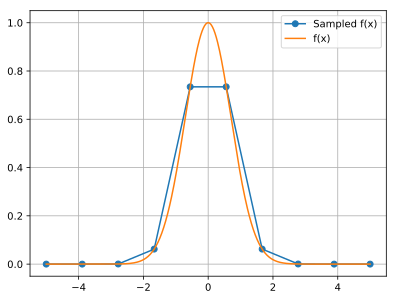

In [49]:
x_dense = np.linspace(x_min,x_max,num=500)
plt.clf()
plt.plot(x, my_gaussian(x), marker="o", label="Sampled f(x)")
plt.plot(x_dense, myfunc_01(x_dense), label="f(x)")
plt.grid()
plt.legend();

Now, think of sampled function values $\psi(x_{i})$ as a column vector and we want to find the value of $\psi''(x_{i})$

In [36]:
def build_D2_matrix(N, h):
    mat = np.zeros( (N,N) )
    for i in range(N):
        mat[i,i] = -2.0/h**2
        if i != N-1:
            mat[i,i+1] = 1/h**2
            mat[i+1,i] = mat[i,i+1]
    return mat

In [38]:
D2 = build_D2_matrix(N,h)

In [50]:
psi = my_gaussian(x)
d2_psi = np.matmul(D2, psi)

In [45]:
def d2_my_gaussian(x, α=1.0):
    return -2*α*np.exp(-α*x**2) + 4 * α**2 * x**2 * np.exp(-α*x**2)

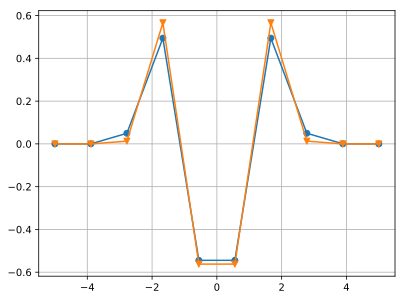

In [51]:
plt.clf()
plt.grid()
plt.plot(x, d2_psi, marker="o")
plt.plot(x, d2_my_gaussian(x), marker="v")

Let's try with more points.

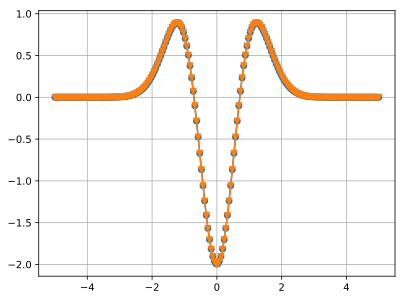

In [70]:
N = 200
x_min = -5.0
x_max = 5.0
L = x_max - x_min
h = L/(N-1)
x = np.zeros(N)
for i in range(N):
    x[i] = x_min + i*h

psi = my_gaussian(x)
D2 = build_D2_matrix(N,h)
d2_psi = np.matmul(D2, psi)

plt.clf()
plt.plot(x, d2_psi, marker="o")
plt.plot(x, d2_my_gaussian(x), marker="v")
plt.grid();

Plot their differences:

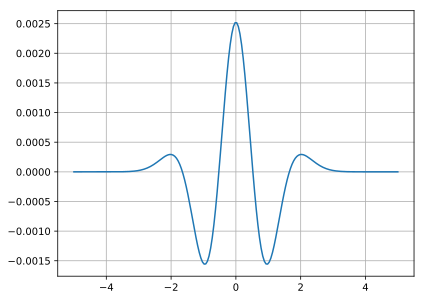

In [55]:
plt.clf()
plt.grid()
plt.plot(x, d2_psi - d2_my_gaussian(x))

In [ ]:
This looks pretty good.

For the first case, we will consider harmonic potential:

$$
V(x) = \frac{1}{2}m \omega^2 x^2
$$

for which we have analytic solutions.

The eigenvalues $E_{n}$ are:

$$
E_{n} = \left( n + \frac{1}{2} \right) \hbar \omega
$$

with $n = 0, 1, 2, \ldots$.

In [56]:
def pot_harmonic(x, ω=1.0):
    return 0.5 * ω**2 * x**2

In [57]:
V_harmonic = pot_harmonic(x)

In [ ]:
plt.clf()
plt.plot(x, V_harmonic);

In [60]:
Ham = np.zeros( (N,N) )
Ham = -0.5*D2[:,:]
for i in range(N):
    Ham[i,i] = Ham[i,i] + V_harmonic[i]
evals, evecs = scipy.linalg.eigh(Ham);

In [62]:
evals[0:3]

array([0.49992108, 1.49960533, 2.49897376])

Compare with the analytic solutions of: $0.5, 1.5, 2.5, \ldots$.

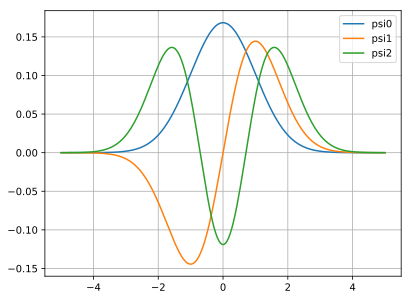

In [65]:
plt.clf()
plt.grid()
plt.plot(x, evecs[:,0], label="psi0")
plt.plot(x, evecs[:,1], label="psi1")
plt.plot(x, evecs[:,2], label="psi2")
plt.legend()

In [66]:
np.dot( evecs[:,0], evecs[:,1] )

2.023879441651717e-13

In [67]:
np.dot( evecs[:,0], evecs[:,2] )

1.457083554391714e-13

In [68]:
np.dot( evecs[:,0], evecs[:,0] )

0.9999999999999993